# RNA-seq Exploratory Data Analysis (EDA) — GEO GSE302199

This notebook performs an exploratory data analysis (EDA) on a public RNA-seq dataset from GEO (GSE302199),
focused on understanding data structure, sample-level QC, sparsity, and the effect of normalization on
multivariate structure (PCA).

**Dataset**: GSE302199 — *HIV-1 transcription dominates over host gene activity at the HIV-1 integration site*  
**Organism**: Homo sapiens  
**Data**: processed feature-level count matrix + GEO series metadata


In [ ]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("Imports OK ✅")

Imports OK ✅


## Dataset overview and analysis strategy

This notebook analyzes RNA-seq data from GEO accession **GSE302199**, a study investigating how HIV-1
transcription behaves relative to host gene activity at the viral integration site.

The analysis follows a deliberately conservative strategy:

1. Load and validate raw count data
2. Inspect sample-level quality metrics (library size, sparsity)
3. Explore global structure using correlation and PCA
4. Assess the impact of normalization
5. Interpret structure in the context of experimental metadata

No filtering or statistical testing is performed until the data structure is fully understood.

In [ ]:
import gdown

file_id = "1vcrHXBUM8weKWzL_H2Qpyl9u1oH7snKO"
url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url, "GSE302199_processed_RNA_count_matrix.csv", quiet=False)

file_id = "1rCozjUp-PcbD3pJVX6aJa_eN3jy7DvtQ"
url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url, "GSE302199_series_matrix.txt", quiet=False)

from pathlib import Path

COUNTS_PATH = Path("GSE302199_processed_RNA_count_matrix.csv")
META_PATH   = Path("GSE302199_series_matrix.txt")

print("\n")
print("Counts exists:", COUNTS_PATH.exists())
print("Meta exists:  ", META_PATH.exists())

assert COUNTS_PATH.exists(), "Counts file not found"
assert META_PATH.exists(), "Metadata file not found"

Downloading...
From: https://drive.google.com/uc?id=1vcrHXBUM8weKWzL_H2Qpyl9u1oH7snKO
To: /content/GSE302199_processed_RNA_count_matrix.csv
100%|██████████| 23.5M/23.5M [00:00<00:00, 79.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rCozjUp-PcbD3pJVX6aJa_eN3jy7DvtQ
To: /content/GSE302199_series_matrix.txt
100%|██████████| 422k/422k [00:00<00:00, 23.1MB/s]



Counts exists: True
Meta exists:   True


## What are these two files?

### 1) Count matrix (`GSE302199_processed_RNA_count_matrix.csv`)
A table where each **row is a genomic feature** (with coordinates / annotations) and each **column is a sample**.
Values are **raw read counts**.

### 2) GEO Series Matrix (`GSE302199_series_matrix.txt`)
Metadata describing each sample (GSM accession, title, and sample characteristics).
This is how we learn what each sample *means* (conditions, treatments, replicate structure, etc.).

**Goal of EDA**: validate that counts + metadata align, then explore QC, sparsity, and structure.

In [ ]:
counts = pd.read_csv(COUNTS_PATH)
print("Counts shape:", counts.shape)

# Identify which columns are feature annotations vs sample columns
feature_cols = ["ID", "Chr", "Start", "End", "Strand", "Length", "Protein_name"]
feature_cols = [c for c in feature_cols if c in counts.columns]
sample_cols = [c for c in counts.columns if c not in feature_cols]

print("Feature annotation cols:", feature_cols)
print("Number of sample cols:", len(sample_cols))
print("First 5 sample cols:", sample_cols[:5])

# Extract numeric matrix
mat = counts[sample_cols].apply(pd.to_numeric, errors="coerce")
assert not mat.isna().any().any(), "Found NA after numeric conversion. Unexpected."

print("Matrix dtype check OK ✅")

Counts shape: (61202, 130)
Feature annotation cols: ['ID', 'Chr', 'Start', 'End', 'Strand', 'Length', 'Protein_name']
Number of sample cols: 123
First 5 sample cols: ['1A8_ga_1', '1A8_ga_2', '1A8_ga_3', '1A8_gi_1', '1A8_gi_2']
Matrix dtype check OK ✅


## Structure of the count matrix

The count matrix consists of:

- **Rows**: genomic features (with chromosomal coordinates and annotations)
- **Columns**: individual RNA-seq samples
- **Values**: raw read counts (integers)

Feature annotation columns are separated from sample columns to ensure that downstream analyses
operate only on numeric expression values.

## Sanity checks on raw counts

Before any transformation or normalization, we verify that the count matrix satisfies
basic assumptions expected for RNA-seq data:

- Counts are non-negative
- Counts are integer-valued
- Sequencing depth varies across samples

These checks confirm that the data represent raw (or integer-preserving processed) read counts
and are suitable for normalization-based analyses.


In [ ]:
# Non-negative?
assert (mat >= 0).all().all(), "Negative values found (unexpected for counts)."

# Integer-ish?
frac_nonint = (mat % 1 != 0).to_numpy().mean()
print("Fraction non-integer:", frac_nonint)

# Basic summary
print("Features:", mat.shape[0], "| Samples:", mat.shape[1])
print("Library size range:", int(mat.sum(axis=0).min()), "to", int(mat.sum(axis=0).max()))


Fraction non-integer: 0.0
Features: 61202 | Samples: 123
Library size range: 3012916 to 74902202


## Sample metadata (GEO Series Matrix)

GEO provides sample annotations in a semi-structured "series matrix" format.
These annotations describe experimental conditions such as:

- cell line
- treatment / perturbation
- replicate information

Because these fields are stored as free-text key–value strings, they must be parsed
and converted into structured columns before they can be used for interpretation.

In [ ]:
def strip_quotes(x: str) -> str:
    x = str(x).strip()
    return x[1:-1] if x.startswith('"') and x.endswith('"') else x

def parse_series_matrix(path: Path):
    series_info = {}
    sample_data = {}
    characteristics_lines = []

    with open(path, "r", errors="ignore") as f:
        for line in f:
            if not line.startswith("!"):
                continue
            parts = line.rstrip("\n").split("\t")
            key = parts[0].lstrip("!")
            vals = [strip_quotes(v) for v in parts[1:]]

            if key.startswith("Series_"):
                series_info[key] = vals[0] if vals else ""
            elif key == "Sample_characteristics_ch1":
                characteristics_lines.append(vals)
            elif key.startswith("Sample_"):
                sample_data[key] = vals

    meta = pd.DataFrame(sample_data)

    # Add repeated characteristics as multiple columns
    for i, vals in enumerate(characteristics_lines, start=1):
        meta[f"characteristics_{i:02d}"] = vals

    return series_info, meta

series_info, meta = parse_series_matrix(META_PATH)

print("Study title:", series_info.get("Series_title", ""))
print("Accession:", series_info.get("Series_geo_accession", ""))
print("Meta shape:", meta.shape)
meta.head(3)

Study title: HIV-1 transcription dominates over host gene activity at the HIV-1 integration site
Accession: GSE302199
Meta shape: (123, 34)


,Sample_title,Sample_geo_accession,Sample_status,Sample_submission_date,Sample_last_update_date,Sample_type,Sample_channel_count,Sample_source_name_ch1,Sample_organism_ch1,Sample_treatment_protocol_ch1,...,Sample_contact_country,Sample_data_row_count,Sample_instrument_model,Sample_library_selection,Sample_library_source,Sample_library_strategy,Sample_relation,Sample_supplementary_file_1,characteristics_01,characteristics_02
0,Jurkat_1A8_EEF2K_CRISPRa_geneTargeting_rep_1,GSM9098387,Public on Oct 21 2025,Jul 09 2025,Oct 21 2025,SRA,1,Jurkat,Homo sapiens,"For CRISPRa, gRNAs were clone into lentiSAMv21...",...,USA,0,Illumina NovaSeq 6000,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,NONE,cell line: Jurkat,treatment: CRISPRa_geneTargeting_EEF2K
1,Jurkat_1A8_EEF2K_CRISPRi_geneTargeting_rep_1,GSM9098388,Public on Oct 21 2025,Jul 09 2025,Oct 21 2025,SRA,1,Jurkat,Homo sapiens,"For CRISPRa, gRNAs were clone into lentiSAMv21...",...,USA,0,Illumina NovaSeq 6000,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,NONE,cell line: Jurkat,treatment: CRISPRi_geneTargeting_EEF2K
2,Jurkat_1A8_EEF2K_CRISPRa_nontargeting_rep_1,GSM9098389,Public on Oct 21 2025,Jul 09 2025,Oct 21 2025,SRA,1,Jurkat,Homo sapiens,"For CRISPRa, gRNAs were clone into lentiSAMv21...",...,USA,0,Illumina NovaSeq 6000,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,NONE,cell line: Jurkat,treatment: CRISPRa_nontargeting


In [ ]:
def explode_characteristics(meta: pd.DataFrame) -> pd.DataFrame:
    char_cols = [c for c in meta.columns if c.startswith("characteristics_")]
    parsed = {}

    # Gather keys
    for col in char_cols:
        for v in meta[col].dropna():
            if ":" in v:
                key = v.split(":", 1)[0].strip().lower()
                parsed.setdefault(key, [""] * len(meta))

    # Fill values
    for i in range(len(meta)):
        for col in char_cols:
            v = str(meta.iloc[i][col])
            if ":" in v:
                k, val = v.split(":", 1)
                k = k.strip().lower()
                if k in parsed:
                    parsed[k][i] = val.strip()

    # Attach columns
    out = meta.copy()
    for k, vals in parsed.items():
        safe = re.sub(r"\W+", "_", k).strip("_")
        out[safe] = vals

    return out

meta2 = explode_characteristics(meta)

print("Meta2 shape:", meta2.shape)
# show parsed keys (the new columns)
new_cols = [c for c in meta2.columns if c not in meta.columns]
print("Parsed fields:", new_cols[:20], "..." if len(new_cols) > 20 else "")
meta2.head(3)

Meta2 shape: (123, 36)
Parsed fields: ['cell_line', 'treatment'] 


,Sample_title,Sample_geo_accession,Sample_status,Sample_submission_date,Sample_last_update_date,Sample_type,Sample_channel_count,Sample_source_name_ch1,Sample_organism_ch1,Sample_treatment_protocol_ch1,...,Sample_instrument_model,Sample_library_selection,Sample_library_source,Sample_library_strategy,Sample_relation,Sample_supplementary_file_1,characteristics_01,characteristics_02,cell_line,treatment
0,Jurkat_1A8_EEF2K_CRISPRa_geneTargeting_rep_1,GSM9098387,Public on Oct 21 2025,Jul 09 2025,Oct 21 2025,SRA,1,Jurkat,Homo sapiens,"For CRISPRa, gRNAs were clone into lentiSAMv21...",...,Illumina NovaSeq 6000,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,NONE,cell line: Jurkat,treatment: CRISPRa_geneTargeting_EEF2K,Jurkat,CRISPRa_geneTargeting_EEF2K
1,Jurkat_1A8_EEF2K_CRISPRi_geneTargeting_rep_1,GSM9098388,Public on Oct 21 2025,Jul 09 2025,Oct 21 2025,SRA,1,Jurkat,Homo sapiens,"For CRISPRa, gRNAs were clone into lentiSAMv21...",...,Illumina NovaSeq 6000,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,NONE,cell line: Jurkat,treatment: CRISPRi_geneTargeting_EEF2K,Jurkat,CRISPRi_geneTargeting_EEF2K
2,Jurkat_1A8_EEF2K_CRISPRa_nontargeting_rep_1,GSM9098389,Public on Oct 21 2025,Jul 09 2025,Oct 21 2025,SRA,1,Jurkat,Homo sapiens,"For CRISPRa, gRNAs were clone into lentiSAMv21...",...,Illumina NovaSeq 6000,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,NONE,cell line: Jurkat,treatment: CRISPRa_nontargeting,Jurkat,CRISPRa_nontargeting


## Parsed metadata fields

After parsing the sample characteristics, we obtain structured metadata columns.
In this dataset, the primary interpretable fields are:

- **cell_line**
- **treatment**

These variables will be used later to interpret global expression patterns.

In [ ]:
assert len(meta2) == len(sample_cols), "Metadata rows and sample columns mismatch."

meta2["counts_column"] = sample_cols  # map by order (as you already validated in Linux)
print("Alignment OK ✅")

# Quick peek at sample naming
meta2[["Sample_geo_accession", "Sample_title", "counts_column"]].head(10)

Alignment OK ✅


,Sample_geo_accession,Sample_title,counts_column
0,GSM9098387,Jurkat_1A8_EEF2K_CRISPRa_geneTargeting_rep_1,1A8_ga_1
1,GSM9098388,Jurkat_1A8_EEF2K_CRISPRi_geneTargeting_rep_1,1A8_ga_2
2,GSM9098389,Jurkat_1A8_EEF2K_CRISPRa_nontargeting_rep_1,1A8_ga_3
3,GSM9098390,Jurkat_1A8_EEF2K_CRISPRi_nontargeting_rep_1,1A8_gi_1
4,GSM9098391,Jurkat_1A8_EEF2K_CRISPRa_HIVTargeting_rep_1,1A8_gi_2
5,GSM9098392,Jurkat_1A8_EEF2K_CRISPRi_HIVTargeting_rep_1,1A8_gi_3
6,GSM9098393,Jurkat_1A8_EEF2K_CRISPRa_geneTargeting_rep_2,1A8_Ha_1
7,GSM9098394,Jurkat_1A8_EEF2K_CRISPRi_geneTargeting_rep_2,1A8_Ha_2
8,GSM9098395,Jurkat_1A8_EEF2K_CRISPRa_nontargeting_rep_2,1A8_Ha_3
9,GSM9098396,Jurkat_1A8_EEF2K_CRISPRi_nontargeting_rep_2,1A8_Hi_1


## Sample-level quality control metrics

To characterize technical and biological variation across samples, we compute
the following QC metrics:

- **Library size**: total counts per sample (sequencing depth proxy)
- **Number of non-zero features**: breadth of detected expression
- **Fraction of zeros**: sparsity of the transcriptome

These metrics help identify extreme samples and contextualize multivariate analyses.

In [ ]:
qc = pd.DataFrame({
    "counts_column": sample_cols,
    "library_size": mat.sum(axis=0).values,
    "n_features_nonzero": (mat > 0).sum(axis=0).values,
    "fraction_zeros": (mat == 0).mean(axis=0).values
})

qc = qc.merge(meta2, how="left", on="counts_column")
qc.head(3)

,counts_column,library_size,n_features_nonzero,fraction_zeros,Sample_title,Sample_geo_accession,Sample_status,Sample_submission_date,Sample_last_update_date,Sample_type,...,Sample_instrument_model,Sample_library_selection,Sample_library_source,Sample_library_strategy,Sample_relation,Sample_supplementary_file_1,characteristics_01,characteristics_02,cell_line,treatment
0,1A8_ga_1,11520753,23818,0.610830,Jurkat_1A8_EEF2K_CRISPRa_geneTargeting_rep_1,GSM9098387,Public on Oct 21 2025,Jul 09 2025,Oct 21 2025,SRA,...,Illumina NovaSeq 6000,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,NONE,cell line: Jurkat,treatment: CRISPRa_geneTargeting_EEF2K,Jurkat,CRISPRa_geneTargeting_EEF2K
1,1A8_ga_2,11239123,23875,0.609898,Jurkat_1A8_EEF2K_CRISPRi_geneTargeting_rep_1,GSM9098388,Public on Oct 21 2025,Jul 09 2025,Oct 21 2025,SRA,...,Illumina NovaSeq 6000,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,NONE,cell line: Jurkat,treatment: CRISPRi_geneTargeting_EEF2K,Jurkat,CRISPRi_geneTargeting_EEF2K
2,1A8_ga_3,12522288,25381,0.585291,Jurkat_1A8_EEF2K_CRISPRa_nontargeting_rep_1,GSM9098389,Public on Oct 21 2025,Jul 09 2025,Oct 21 2025,SRA,...,Illumina NovaSeq 6000,cDNA,transcriptomic,RNA-Seq,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,NONE,cell line: Jurkat,treatment: CRISPRa_nontargeting,Jurkat,CRISPRa_nontargeting


In [ ]:
# Save key tables for reuse / download
qc.to_csv("qc_table.csv", index=False)
meta2.to_csv("metadata_parsed.csv", index=False)

print("Saved files:")
print("- qc_table.csv")
print("- metadata_parsed.csv")

Saved files:
- qc_table.csv
- metadata_parsed.csv


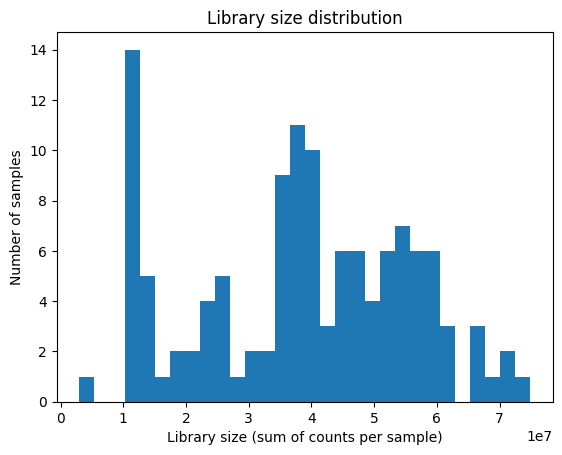

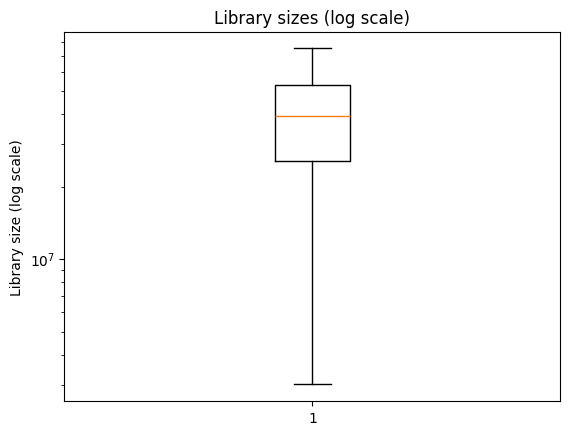

In [ ]:
plt.figure()
plt.hist(qc["library_size"], bins=30)
plt.xlabel("Library size (sum of counts per sample)")
plt.ylabel("Number of samples")
plt.title("Library size distribution")
plt.show()

plt.figure()
plt.boxplot(qc["library_size"], vert=True)
plt.yscale("log")
plt.ylabel("Library size (log scale)")
plt.title("Library sizes (log scale)")
plt.show()

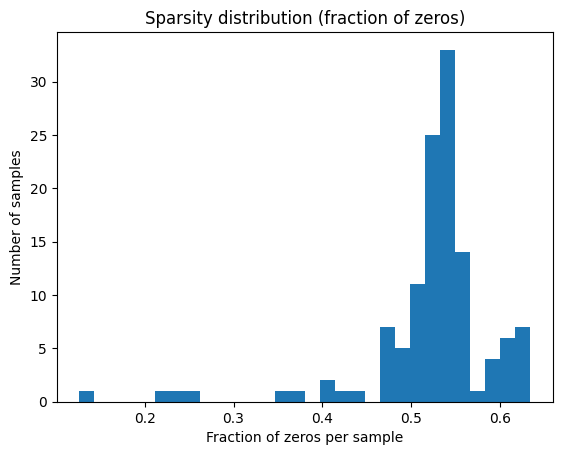

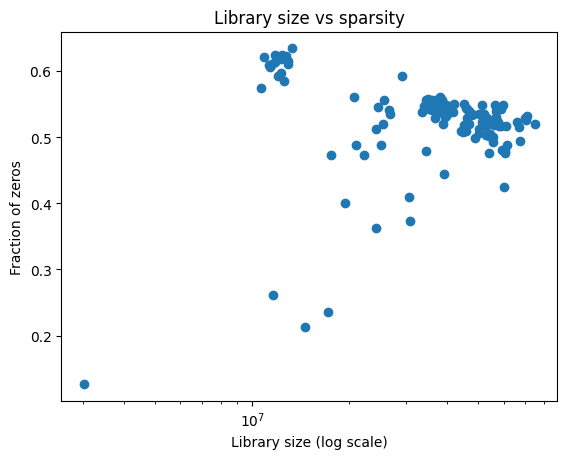

In [ ]:
plt.figure()
plt.hist(qc["fraction_zeros"], bins=30)
plt.xlabel("Fraction of zeros per sample")
plt.ylabel("Number of samples")
plt.title("Sparsity distribution (fraction of zeros)")
plt.show()

plt.figure()
plt.scatter(qc["library_size"], qc["fraction_zeros"])
plt.xscale("log")
plt.xlabel("Library size (log scale)")
plt.ylabel("Fraction of zeros")
plt.title("Library size vs sparsity")
plt.show()

## Sample–sample correlation structure

To assess whether samples exhibit coherent expression patterns, we compute
pairwise correlations across samples using the most variable features.

If samples cluster into blocks of high correlation, this suggests structured
biological signal rather than random noise.

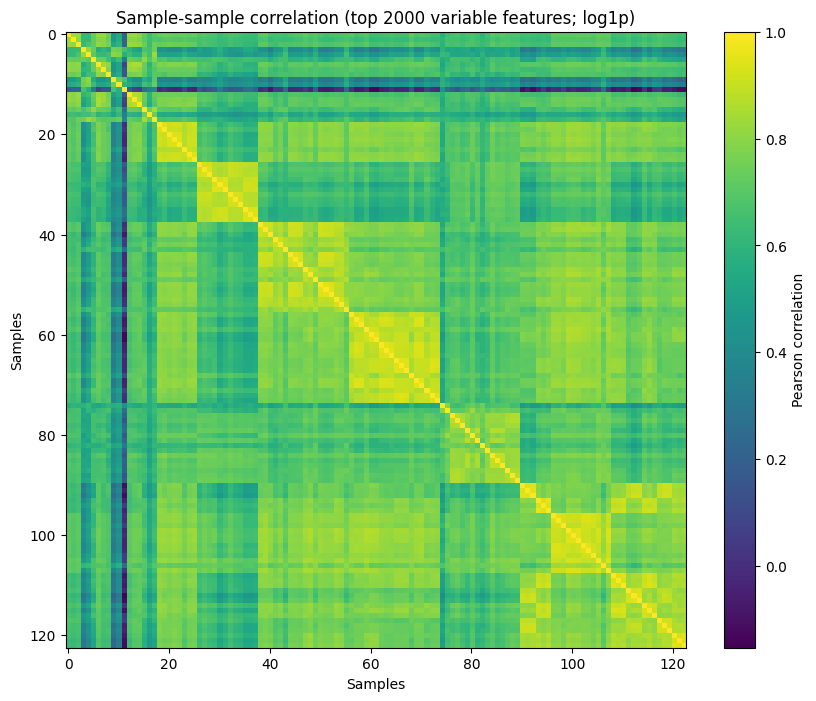

In [ ]:
log1p = np.log1p(mat)

# Top variable features
v = log1p.var(axis=1)
top_n = 2000
top_idx = v.nlargest(top_n).index
log1p_top = log1p.loc[top_idx]

corr = log1p_top.corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr.values, aspect="auto")
plt.colorbar(label="Pearson correlation")
plt.title(f"Sample-sample correlation (top {top_n} variable features; log1p)")
plt.xlabel("Samples")
plt.ylabel("Samples")
plt.show()

In [ ]:
def pca_2d(features_x_samples: pd.DataFrame):
    X = features_x_samples.T.values  # samples x features
    X = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

    pca = PCA(n_components=2, random_state=42)
    coords = pca.fit_transform(X)
    expl = pca.explained_variance_ratio_
    return coords, expl

## Principal Component Analysis (PCA) on raw counts

PCA is used to summarize global variation across samples.
Here, PCA is first applied to log-transformed raw counts.

At this stage, principal components may still be influenced by technical factors
such as sequencing depth and compositional bias.

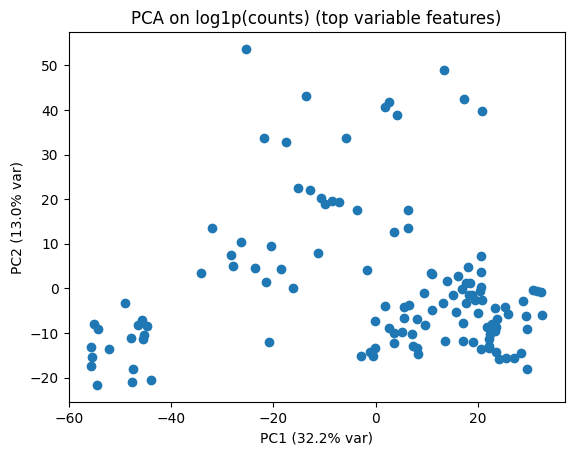

In [ ]:
coords_raw, expl_raw = pca_2d(log1p_top)

plt.figure()
plt.scatter(coords_raw[:, 0], coords_raw[:, 1])
plt.xlabel(f"PC1 ({expl_raw[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({expl_raw[1]*100:.1f}% var)")
plt.title("PCA on log1p(counts) (top variable features)")
plt.show()

## PCA after normalization (CPM + log transform)

Counts are normalized to counts-per-million (CPM) to reduce sequencing depth effects,
followed by log transformation.

Comparing PCA before and after normalization illustrates how technical variation
can dominate raw expression data and how normalization clarifies biological structure.

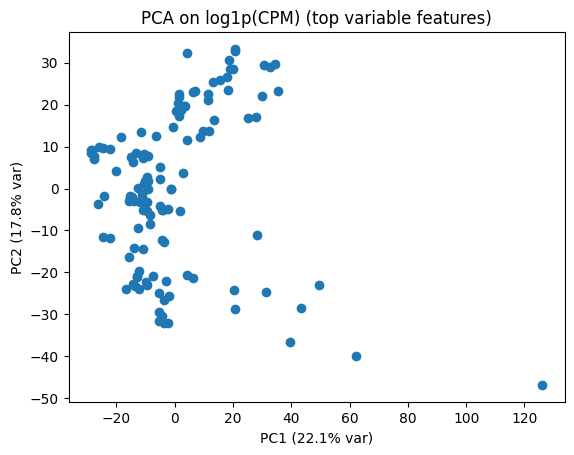

In [ ]:
# CPM normalize
lib = mat.sum(axis=0)
cpm = mat.div(lib, axis=1) * 1e6
log1p_cpm = np.log1p(cpm)

# Top variable on CPM scale
v2 = log1p_cpm.var(axis=1)
top_idx2 = v2.nlargest(2000).index
log1p_cpm_top = log1p_cpm.loc[top_idx2]

coords_cpm, expl_cpm = pca_2d(log1p_cpm_top)

plt.figure()
plt.scatter(coords_cpm[:, 0], coords_cpm[:, 1])
plt.xlabel(f"PC1 ({expl_cpm[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({expl_cpm[1]*100:.1f}% var)")
plt.title("PCA on log1p(CPM) (top variable features)")
plt.show()

## Interpretation checkpoint

- Library sizes vary substantially → raw counts are not directly comparable.
- Sparsity (zeros) is expected in RNA-seq and varies across samples.
- Correlation structure suggests coherent grouping (not random noise).
- PCA on raw log1p(counts) is more influenced by depth/composition.
- PCA on log1p(CPM) reduces technical effects and reveals clearer structure.

Next step: color PCA points by metadata (treatment / clone / condition) to interpret biological drivers.

## Interpreting PCA using experimental metadata

To understand the biological drivers of global expression variation, PCA coordinates
are colored by experimental metadata.

We first examine cell line effects, followed by treatment-specific effects,
to determine which factors dominate transcriptomic structure.

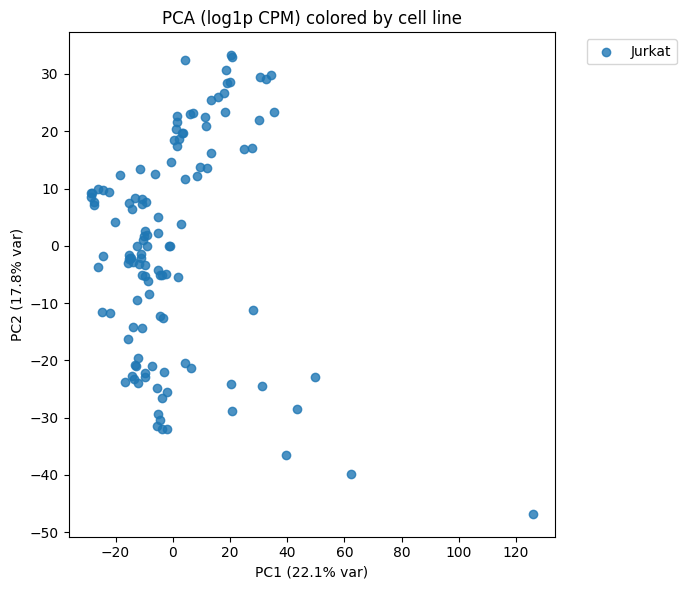

In [ ]:
# PCA colored by cell_line

# Build a dataframe with PCA coords + metadata
pca_df = pd.DataFrame({
    "PC1": coords_cpm[:, 0],
    "PC2": coords_cpm[:, 1],
    "cell_line": qc["cell_line"].values,
    "treatment": qc["treatment"].values
})

plt.figure(figsize=(7, 6))
for cl in sorted(pca_df["cell_line"].dropna().unique()):
    idx = pca_df["cell_line"] == cl
    plt.scatter(
        pca_df.loc[idx, "PC1"],
        pca_df.loc[idx, "PC2"],
        label=cl,
        alpha=0.8
    )

plt.xlabel(f"PC1 ({expl_cpm[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({expl_cpm[1]*100:.1f}% var)")
plt.title("PCA (log1p CPM) colored by cell line")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

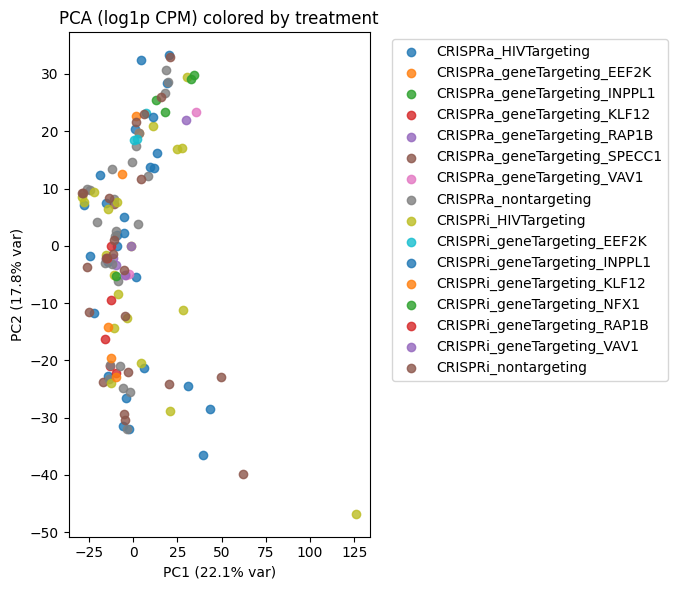

In [ ]:
# PCA colored by treatment

plt.figure(figsize=(7, 6))
for tr in sorted(pca_df["treatment"].dropna().unique()):
    idx = pca_df["treatment"] == tr
    plt.scatter(
        pca_df.loc[idx, "PC1"],
        pca_df.loc[idx, "PC2"],
        label=tr,
        alpha=0.8
    )

plt.xlabel(f"PC1 ({expl_cpm[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({expl_cpm[1]*100:.1f}% var)")
plt.title("PCA (log1p CPM) colored by treatment")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Interpretation of PCA results

All samples in this dataset originate from a single cell line, **Jurkat**, as confirmed by
the absence of multiple groups in the PCA colored by cell line. Consequently, global
transcriptional variation cannot be attributed to differences in baseline cell identity.

When PCA coordinates are colored by treatment, no strong or discrete clustering is observed.
Instead, samples from different treatments show substantial overlap, with only partial
structure emerging along the principal components.

This pattern suggests that CRISPR-based perturbations in this study do not induce large,
global shifts in the transcriptome. Rather, their effects are likely targeted, gene-specific,
and heterogeneous across samples, consistent with the expected behavior of CRISPRa and
CRISPRi perturbations.

Importantly, the absence of strong clustering does not indicate a lack of biological signal,
but instead reflects subtle and context-dependent transcriptional responses.


## Global comparison of perturbation modes (CRISPRa vs CRISPRi)

While individual treatments target specific genes, they can be grouped into broader
perturbation *modes*:

- **CRISPRa**: transcriptional activation
- **CRISPRi**: transcriptional repression
- **Non-targeting controls**

Collapsing treatments into these categories allows us to ask a higher-level question:

> Does activation vs repression induce distinct global transcriptional signatures,
> even if individual gene targets differ?

In the following analysis, treatments are grouped by perturbation mode and re-examined
using PCA.

In [ ]:
def map_perturbation_mode(t: str) -> str:
    t = str(t)
    t_low = t.lower()

    if "nontargeting" in t_low:
        return "Control"
    if t.startswith("CRISPRa_"):
        return "CRISPRa"
    if t.startswith("CRISPRi_"):
        return "CRISPRi"
    return "Other/Unknown"

qc["perturbation_mode"] = qc["treatment"].apply(map_perturbation_mode)

qc["perturbation_mode"].value_counts()

,count
perturbation_mode,
Control,45
CRISPRa,40
CRISPRi,38


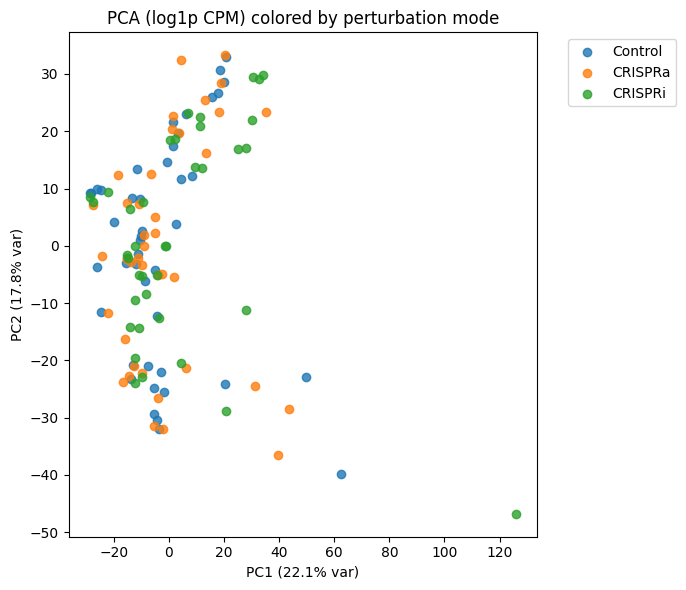

In [ ]:
pca_mode = pd.DataFrame({
    "PC1": coords_cpm[:, 0],
    "PC2": coords_cpm[:, 1],
    "perturbation_mode": qc["perturbation_mode"].values,
    "treatment": qc["treatment"].values,  # keep for later
})

plt.figure(figsize=(7, 6))
order = ["Control", "CRISPRa", "CRISPRi", "Other/Unknown"]

for mode in [m for m in order if m in set(pca_mode["perturbation_mode"])]:
    idx = pca_mode["perturbation_mode"] == mode
    plt.scatter(pca_mode.loc[idx, "PC1"], pca_mode.loc[idx, "PC2"], label=mode, alpha=0.8)

plt.xlabel(f"PC1 ({expl_cpm[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({expl_cpm[1]*100:.1f}% var)")
plt.title("PCA (log1p CPM) colored by perturbation mode")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
summary = (
    pca_mode.groupby("perturbation_mode")[["PC1", "PC2"]]
    .agg(["mean", "median", "std", "count"])
    .sort_index()
)

summary

PC1                                  PC2            \
                       mean    median        std count      mean    median   
perturbation_mode                                                            
CRISPRa           -0.944947 -5.144597  17.312156    40 -1.147609 -1.962141   
CRISPRi            4.185436 -2.433217  26.819148    38  1.662133 -0.024134   
Control           -2.694415 -5.271963  18.478270    45 -0.383482  1.762493   

                                    
                         std count  
perturbation_mode                   
CRISPRa            19.745553    40  
CRISPRi            18.226748    38  
Control            19.177767    45

## Perturbation mode does not strongly separate samples

After collapsing detailed treatment labels into three perturbation modes (Control, CRISPRa, CRISPRi),
PCA on log1p(CPM)-normalized counts shows substantial overlap between groups. Group mean PC scores
differ only modestly relative to the large within-group variability, suggesting that global
transcriptomic structure is not dominated by perturbation mode in PC1/PC2.

This supports the interpretation that CRISPR perturbations primarily induce targeted, gene-specific
effects rather than large transcriptome-wide shifts, and that sample-to-sample heterogeneity (or
other biological factors) contributes strongly to the leading PCs.

## Identifying features driving global variation (PC1)

PCA reveals substantial global variation that is not cleanly explained by treatment labels.
To understand the biological origin of this variation, we examine the **feature loadings**
of the first principal component (PC1).

Features with large positive or negative loadings on PC1 contribute most strongly to the
dominant transcriptional pattern in the dataset. Inspecting these features allows us to
infer which genes or genomic regions drive global sample separation.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# X = samples x features
X = log1p_cpm_top.T.values

# Standardize features (important for loadings interpretation)
X_scaled = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

# Fit PCA
pca = PCA(n_components=5, random_state=42)
coords = pca.fit_transform(X_scaled)

# Explained variance
pca.explained_variance_ratio_

array([0.22094846, 0.17822933, 0.08383701, 0.07430399, 0.06288875])

In [ ]:
# PC1 loadings: contribution of each feature
pc1_loadings = pd.Series(
    pca.components_[0],
    index=log1p_cpm_top.index
).sort_values(key=np.abs, ascending=False)

pc1_loadings.head(20)

,0
42796,0.041126
49783,0.040613
10821,0.040597
22696,0.040011
14667,0.039821
47666,0.039713
42465,0.039629
3689,0.039554
29445,0.039503
42463,0.039437


In [ ]:
top_features = pc1_loadings.head(20).index

feature_info = counts.loc[
    counts.index.isin(top_features),
    ["ID", "Chr", "Start", "End", "Strand", "Length", "Protein_name"]
]

feature_info.assign(PC1_loading=pc1_loadings.loc[top_features].values)

,ID,Chr,Start,End,Strand,Length,Protein_name,PC1_loading
3689,ENSG00000272668.2,chr1,159854870,159854968,+,7134,ENSG00000272668,0.041126
5421,ENSG00000162849.16,chr1,245154985,245155487,+,13720,KIF26B,0.040613
6871,ENSG00000115318.12,chr2,74532258,74533679,-,4300,LOXL3,0.040597
10821,ENSG00000157388.20,chr3,53328963,53329444,+,11875,CACNA1D,0.040011
14667,ENSG00000145362.21,chr4,112818032,112818264,+,18115,ANK2,0.039821
22696,ENSG00000179869.15,chr7,48171458,48171552,+,17188,ABCA13,0.039713
29445,ENSG00000050555.19,chr9,131009174,131009587,+,7455,LAMC3,0.039629
42332,ENSG00000181984.11,chr15,20562375,20562520,+,5237,GOLGA8CP,0.039554
42435,ENSG00000291002.1,chr15,22427039,22427818,-,2786,ENSG00000291002,0.039503
42463,ENSG00000273976.2,chr15,23127066,23128813,-,3822,GOLGA6L1,0.039437


## Interpretation of PC1-driving features

Inspection of the features with the largest absolute loadings on PC1 reveals that global
variation is driven primarily by host genes rather than HIV-derived transcripts.
The top contributors include large, highly expressed genes involved in cellular structure,
signaling, vesicle trafficking, and membrane-associated processes (e.g. CACNA1D, ANK2,
ABCA13, and multiple GOLGA family members).

The prominence of these features suggests that PC1 captures heterogeneity in host
transcriptional programs rather than a single experimental perturbation. This explains why
samples do not separate cleanly by treatment or perturbation mode despite clear global
structure in PCA.

Overall, the dominant axis of variation reflects intrinsic or context-dependent host
transcriptional states, consistent with subtle and gene-specific effects of CRISPR-based
perturbations.

## Secondary axes of variation (PC2 and PC3)

While PC1 captures the dominant source of global variation, biologically relevant
signals may also be present in secondary principal components. We therefore examine
the features driving PC2 and PC3 to assess whether additional structure—potentially
related to HIV transcription or specific perturbations—is captured beyond PC1.

In [ ]:
# PC2 and PC3 loadings
pc2_loadings = pd.Series(
    pca.components_[1],
    index=log1p_cpm_top.index
).sort_values(key=np.abs, ascending=False)

pc3_loadings = pd.Series(
    pca.components_[2],
    index=log1p_cpm_top.index
).sort_values(key=np.abs, ascending=False)

pc2_loadings.head(15), pc3_loadings.head(15)

(13785    0.047560
 40520   -0.046249
 53163   -0.046038
 53708    0.045090
 18427   -0.044938
 9221     0.044818
 57972    0.044614
 41176    0.044517
 53165   -0.044219
 2977    -0.044184
 27806    0.043798
 56943   -0.043639
 9222     0.043491
 30765   -0.043474
 33590    0.043471
 dtype: float64,
 915      0.057858
 52387    0.057285
 45051    0.056128
 28344    0.055558
 34907    0.054893
 28347    0.054817
 41045    0.054517
 48727    0.054095
 39786    0.053640
 48013    0.053021
 51945    0.052473
 19112    0.052349
 58267    0.052092
 58270    0.051085
 3044     0.051085
 dtype: float64)

In [ ]:
top_pc2 = pc2_loadings.head(15).index
top_pc3 = pc3_loadings.head(15).index

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 200)
pd.set_option("display.expand_frame_repr", False)

pc2_features = counts.loc[top_pc2, ["ID","Chr","Start","End","Strand","Length","Protein_name"]]
pc2_features["PC2_loading"] = pc2_loadings.loc[top_pc2].values

pc3_features = counts.loc[top_pc3, ["ID","Chr","Start","End","Strand","Length","Protein_name"]]
pc3_features["PC3_loading"] = pc3_loadings.loc[top_pc3].values

pc2_features, pc3_features

(                       ID    Chr      Start        End Strand  Length     Protein_name  PC2_loading
 13785  ENSG00000184178.17   chr4   52872982   52874061      -    3162            SCFD2     0.047560
 40520   ENSG00000197358.9  chr14   28264390   28265974      +    1585          BNIP3P1    -0.046249
 53163  ENSG00000167642.13  chr19   38264573   38264998      +    1688           SPINT2    -0.046038
 53708  ENSG00000105447.13  chr19   48445983   48446192      +    5361            GRWD1     0.045090
 18427  ENSG00000113739.11   chr5  173314723  173318249      -    4254             STC2    -0.044938
 9221    ENSG00000279348.1   chr2  216211404  216213519      +    2116  ENSG00000279348     0.044818
 57972  ENSG00000100413.17  chr22   41525799   41529336      -    4583           POLR3H     0.044614
 41176   ENSG00000198133.9  chr14   67470269   67473941      -    4152         TMEM229B     0.044517
 53165   ENSG00000267748.4  chr19   38289168   38289191      +     528  ENSG00000267748    

## Interpretation of secondary PCA axes (PC2 and PC3)

Analysis of PC2- and PC3-driving features reveals additional biologically meaningful
structure beyond the dominant PC1 axis. PC2 is enriched for genes involved in cellular
stress responses, transcriptional regulation, and RNA metabolism (e.g. STC2, BNIP3P1,
EGR2, POLR3H), suggesting that this axis reflects heterogeneous transcriptional activity
or response states across samples.

In contrast, PC3 is driven by immune- and lymphocyte-associated genes (e.g. CD52, CCR7,
SOCS1, POU2AF1), consistent with variability in immune signaling programs within the
Jurkat T-cell background.

Together, these results indicate that global transcriptomic variation in this dataset
is structured across multiple biological dimensions, including host transcriptional
programs, cellular response states, and immune signaling, rather than being dominated
by experimental treatment labels alone.

## Subset analysis: controlling for background transcriptional heterogeneity

Global PCA analyses indicate that host transcriptional programs dominate overall
variation in the dataset. To assess whether HIV-specific perturbations induce clearer
structure when unrelated targets are excluded, we perform a focused subset analysis
restricted to HIV-targeting and non-targeting control samples.

This analysis does not aim to increase apparent separation, but to evaluate whether
HIV-related effects are detectable when background transcriptional heterogeneity is
reduced.

In [ ]:
subset_mask = qc["treatment"].apply(
    lambda t: ("HIVTargeting" in str(t)) or ("nontargeting" in str(t).lower())
)

qc_sub = qc.loc[subset_mask].copy()

sub_cols = qc_sub["counts_column"].values
log1p_cpm_sub = log1p_cpm.loc[:, sub_cols]

In [ ]:
X_sub = log1p_cpm_sub.T.values
X_sub_scaled = StandardScaler().fit_transform(X_sub)

pca_sub = PCA(n_components=3, random_state=42)
coords_sub = pca_sub.fit_transform(X_sub_scaled)
expl_sub = pca_sub.explained_variance_ratio_

pca_sub_df = pd.DataFrame({
    "PC1": coords_sub[:, 0],
    "PC2": coords_sub[:, 1],
    "group": qc_sub["treatment"].apply(
        lambda t: "HIVTargeting" if "HIVTargeting" in t else "Control"
    ).values
})

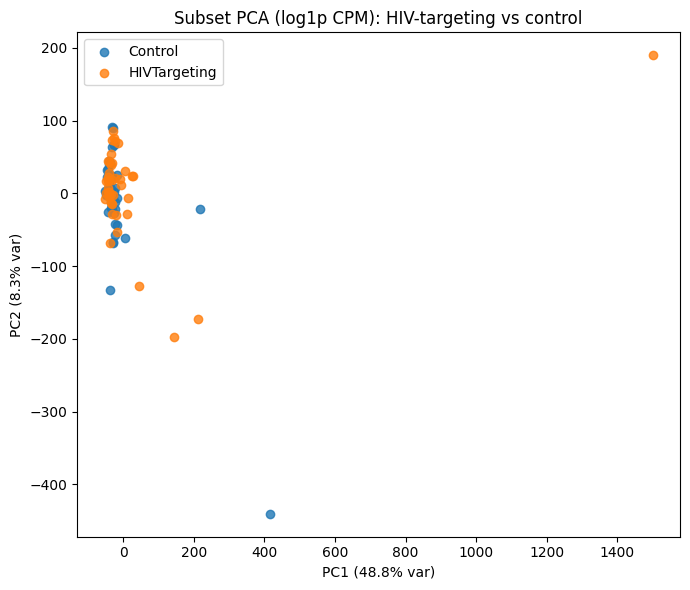

In [ ]:
plt.figure(figsize=(7, 6))
for g in ["Control", "HIVTargeting"]:
    idx = pca_sub_df["group"] == g
    plt.scatter(
        pca_sub_df.loc[idx, "PC1"],
        pca_sub_df.loc[idx, "PC2"],
        label=g,
        alpha=0.8
    )

plt.xlabel(f"PC1 ({expl_sub[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({expl_sub[1]*100:.1f}% var)")
plt.title("Subset PCA (log1p CPM): HIV-targeting vs control")
plt.legend()
plt.tight_layout()
plt.show()

## Interpretation of subset PCA (HIV-targeting vs control)

Restricting the analysis to HIV-targeting and non-targeting control samples substantially
increases the proportion of variance explained by the first principal component (PC1),
indicating that background transcriptional heterogeneity from unrelated perturbations
previously masked dominant signals.

Despite this, HIV-targeting and control samples do not form discrete, well-separated
clusters. Instead, HIV-targeting samples exhibit increased dispersion and several extreme
outliers along PC1 and PC2, suggesting heterogeneous transcriptional responses to HIV-
specific perturbations.

These results indicate that HIV-targeting does not induce a uniform global transcriptional
shift across samples, but can drive strong, context-dependent effects in a subset of cases,
consistent with variability in viral integration context and perturbation efficiency.

## Illustrative gene-level example: EGR2

To make the PCA results more concrete, we examine the expression pattern of a single
gene that contributes strongly to PC2. EGR2 is an immediate early gene involved in
transcriptional regulation and cellular response signaling, making it a useful
illustrative example for heterogeneous transcriptional states.

In [ ]:
gene = "EGR2"

# Find the row corresponding to EGR2
gene_row = counts[counts["Protein_name"] == gene]

assert gene_row.shape[0] == 1, "Expected exactly one row for EGR2"

gene_id = gene_row.index[0]

# Extract expression (log1p CPM) for all samples
egr2_expr = log1p_cpm.loc[gene_id]

# Build plotting dataframe
egr2_df = pd.DataFrame({
    "expression": egr2_expr.values,
    "group": qc["treatment"].apply(
        lambda t: "HIVTargeting" if "HIVTargeting" in t else
                  ("Control" if "nontargeting" in t.lower() else "Other")
    ).values
})

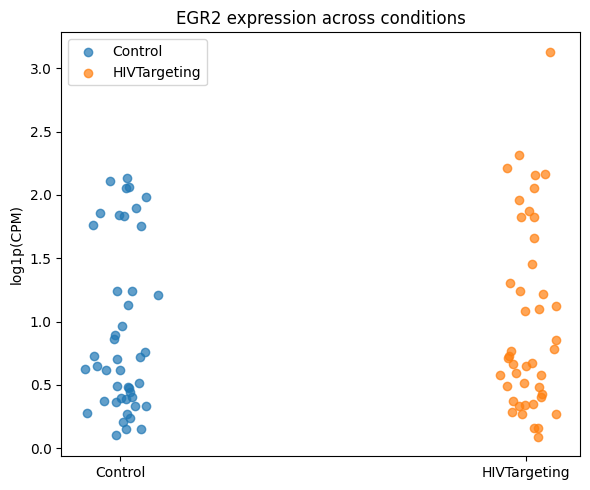

In [ ]:
plt.figure(figsize=(6,5))

groups = ["Control", "HIVTargeting"]
xpos = {g:i for i,g in enumerate(groups)}

for g in groups:
    vals = egr2_df.loc[egr2_df["group"] == g, "expression"]
    x = np.random.normal(xpos[g], 0.04, size=len(vals))
    plt.scatter(x, vals, alpha=0.7, label=g)

plt.xticks([0,1], groups)
plt.ylabel("log1p(CPM)")
plt.title("EGR2 expression across conditions")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
egr2_df.groupby("group")["expression"].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
Control,45.0,0.903286,0.658473,0.105458,0.390658,0.650220,1.244685,2.131618
HIVTargeting,44.0,1.004715,0.740503,0.087857,0.420763,0.720984,1.508377,3.131385
Other,34.0,0.785674,0.458813,0.000000,0.484192,0.620779,1.201454,1.702125


## Descriptive summary of EGR2 expression

Summary statistics further support the gene-level visualization. Median and mean EGR2
expression levels are similar between HIV-targeting and control samples, while the
HIV-targeting group exhibits increased variance and a higher upper expression range.
This indicates that HIV-specific perturbations are associated with greater transcriptional
heterogeneity rather than a uniform shift in expression.

Such variability is consistent with EGR2’s role as an immediate early response gene and
illustrates how heterogeneous gene-level behavior can contribute to principal components
without producing clear group separation.

EGR2 is presented as a representative illustrative example rather than a comprehensive
gene-level analysis.

## Conclusions

In this exploratory analysis, we examined a publicly available RNA-seq dataset
(GSE302199) profiling Jurkat T cells under CRISPR-based perturbations related to
HIV transcriptional regulation. Using basic quality control, normalization, and
unsupervised dimensionality reduction, we explored global and subset-specific
transcriptional structure without imposing strong a priori assumptions.

Key observations include:

- Global quality control metrics indicated substantial variability in library size
  and sparsity across samples, motivating the use of log-transformed CPM values.
- Principal component analysis revealed that the dominant sources of variance were
  not driven by treatment labels alone, but by heterogeneous transcriptional response
  states across samples.
- Subsetting the data to HIV-targeting versus control conditions increased the
  variance explained by the leading principal component, suggesting that HIV-specific
  perturbations contribute to—but do not fully determine—global transcriptional
  structure.
- Examination of PCA feature loadings identified response-associated genes as major
  contributors to secondary components.
- A gene-level illustrative example (EGR2) demonstrated that increased transcriptional
  heterogeneity, rather than uniform expression shifts, can underlie principal
  component structure.

Overall, this analysis highlights how unsupervised exploratory approaches can reveal
complex, heterogeneous transcriptional responses that are not captured by simple
group-wise comparisons.

---

## Limitations

This analysis was intentionally exploratory and has several limitations:

- No formal differential expression testing was performed; all observations are
  descriptive and hypothesis-generating.
- Batch effects, technical covariates, and experimental confounders were not modeled
  explicitly and may contribute to observed variance.
- Feature selection was limited to highly variable genes, which may bias PCA toward
  response-associated transcripts.
- Gene-level interpretation was restricted to illustrative examples and does not
  represent a systematic characterization of regulatory mechanisms.
- Results are specific to Jurkat T cells and may not generalize to primary cells or
  other experimental systems.

Future analyses could extend this work by incorporating statistical modeling,
covariate adjustment, pathway-level interpretation, and integration with additional
omics or perturbation datasets.